### All imports

In [12]:
import os
from dotenv import load_dotenv
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain.retrievers.multi_query import MultiQueryRetriever
from datasets import Dataset
from langchain.retrievers import EnsembleRetriever
from langchain_community.retrievers import BM25Retriever
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain_community.document_loaders import TextLoader
from langchain_openai import OpenAIEmbeddings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from langchain_community.document_transformers import EmbeddingsRedundantFilter
from langchain.retrievers.document_compressors import DocumentCompressorPipeline
from langchain.text_splitter import CharacterTextSplitter
from langchain.retrievers.document_compressors import EmbeddingsFilter
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain.storage import InMemoryStore
from langchain.retrievers import ParentDocumentRetriever

/home/daisy/Desktop/tenx/ContractAdvisorRAG/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:

load_dotenv()

def pretty_print_docs(docs):
    print(f"\n{'-' * 100}\n".join([f"Document {i+1}:\n" + d.page_content for i, d in enumerate(docs)]))

embedding = OpenAIEmbeddings()

### Loader

In [2]:
loader = TextLoader("../data/Raptor.txt")
data = loader.load()
loader = TextLoader("../data/Robinson.txt")
data2 = loader.load()

data = data + data2

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
docs = text_splitter.split_documents(data)

### Cosine Similarity

In [3]:
vector1 = embedding.embed_query("What is the capital city of Canada?")
vector2 = embedding.embed_query("How much is the escrow amount?")
vector3 = embedding.embed_query("In which street does the Advisor live?")

data_vectors = [embedding.embed_query(doc.page_content) for doc in docs]
print(len(data_vectors))

669


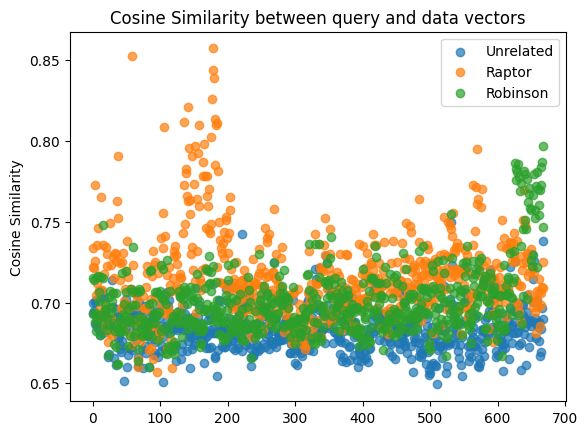

In [4]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np

cosine_sims_1 = [cosine_similarity([vector1], [data_vector])[0][0] for data_vector in data_vectors]
cosine_sims_2 = [cosine_similarity([vector2], [data_vector])[0][0] for data_vector in data_vectors]
cosine_sims_3 = [cosine_similarity([vector3], [data_vector])[0][0] for data_vector in data_vectors]

x = np.arange(len(data_vectors))

plt.scatter(x, cosine_sims_1, label='Unrelated', alpha=0.7)
plt.scatter(x, cosine_sims_2, label='Raptor', alpha=0.7)
plt.scatter(x, cosine_sims_3, label='Robinson', alpha=0.7)

plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity between query and data vectors')
plt.legend()

plt.show()

### ParentDocumentRetriever

In [5]:

child_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
parent_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=50)
vectorstore = Chroma(
    collection_name="full_documents", embedding_function=embedding
)
store = InMemoryStore()
retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=store,
    child_splitter=child_splitter,
    parent_splitter=parent_splitter
)

In [6]:
retriever.add_documents(docs, ids=None)

In [8]:
vectorstore.similarity_search("In which street does the Advisor live?")

[Document(page_content='8. Jurisdiction: This Undertaking shall be governed by and construed in accordance with the laws of the State of Israel, without giving effect to its laws pertaining to conflict of laws.  The Advisor agrees that any and all disputes in connection with this Undertaking shall be submitted to the exclusive jurisdiction of the competent courts in the city of Tel Aviv-Yafo, Israel.', metadata={'doc_id': '252a7992-5782-4806-9f70-5b672f560cf0', 'source': '../data/Robinson.txt'}),
 Document(page_content='belonging to the Advisor and/or any third party while performing the Services and in case any Advisor proprietary or confidential information is used, such information will be automatically assigned to the Company and become its full and exclusive property.', metadata={'doc_id': '05b3a378-ab20-419a-8da5-f86b6b01d626', 'source': '../data/Robinson.txt'}),
 Document(page_content='\ufeff- -\n\n\nADVISORY SERVICES AGREEMENT\nThis Advisory Services Agreement is entered into a

In [10]:
retriever.invoke("In which street does the Advisor live?")

[Document(page_content='8. Jurisdiction: This Undertaking shall be governed by and construed in accordance with the laws of the State of Israel, without giving effect to its laws pertaining to conflict of laws.  The Advisor agrees that any and all disputes in connection with this Undertaking shall be submitted to the exclusive jurisdiction of the competent courts in the city of Tel Aviv-Yafo, Israel.', metadata={'source': '../data/Robinson.txt'}),
 Document(page_content='belonging to the Advisor and/or any third party while performing the Services and in case any Advisor proprietary or confidential information is used, such information will be automatically assigned to the Company and become its full and exclusive property.', metadata={'source': '../data/Robinson.txt'}),
 Document(page_content='\ufeff- -\n\n\nADVISORY SERVICES AGREEMENT\nThis Advisory Services Agreement is entered into as of June 15th, 2023 (the “Effective Date”), by and between Cloud Investments Ltd., ID 51-426526-3, 

In [15]:
llm = ChatOpenAI(model="gpt-3.5-turbo", openai_api_key=os.getenv("OPENAI_API_KEY"))

rag_chain = RetrievalQA.from_chain_type(llm, chain_type="stuff", retriever=retriever)

def rag_qa(query):
    response = rag_chain.invoke(query)
    return response

query = "In which street does the Advisor live?"
answer = rag_qa(query)
print(answer)

{'query': 'In which street does the Advisor live?', 'result': 'The Advisor, Mr. Jack Robinson, resides at 1 Rabin St, Tel Aviv, Israel.'}


### MultiQueryRetriever

In [19]:
llm = ChatOpenAI(
        model="gpt-3.5-turbo",
        openai_api_key=os.getenv("OPENAI_API_KEY"),
        temperature=0,
        max_tokens=800,
        model_kwargs={"top_p": 0, "frequency_penalty": 0, "presence_penalty": 0},
    )


retriever = MultiQueryRetriever.from_llm(
    retriever=vectorstore.as_retriever(), llm=llm
)

In [20]:
unique_docs = retriever.get_relevant_documents("How much is the escrow amount?")
len(unique_docs)

5

In [21]:
rag_chain = RetrievalQA.from_chain_type(llm, chain_type="stuff", retriever=retriever)

def rag_qa(query):
    response = rag_chain.invoke(query)
    return response

query = "How much is the escrow amount?"
answer = rag_qa(query)
print(answer)

{'query': 'How much is the escrow amount?', 'result': 'The escrow amount is $1,000,000.'}


In [22]:
question = "What are the payments to the Advisor under the Agreement?"


### Contextual Compression

In [23]:
vectorstore = Chroma(
    collection_name="full_documents", embedding_function=embedding
)
vectorstore.add_documents(docs)
retriever = vectorstore.as_retriever()

In [24]:
retriever.get_relevant_documents(query=question)

[Document(page_content="it is adjudicated or otherwise determined by any governmental authority that the Advisor and/or anyone on Advisor's behalf, is, regardless of the terms of this Agreement, an employee of the Company, then payments to Advisor hereunder shall be reduced effective retroactively as of the beginning of the Term so that 60% of such payments shall constitute salary payments, and 40% of such payments shall constitute payment by the Company for all other Advisor statutory rights and benefits as employee", metadata={'doc_id': '774ff276-6a1e-476a-8ee4-a434e3003fda', 'source': '../data/Robinson.txt'}),
 Document(page_content="it is adjudicated or otherwise determined by any governmental authority that the Advisor and/or anyone on Advisor's behalf, is, regardless of the terms of this Agreement, an employee of the Company, then payments to Advisor hereunder shall be reduced effective retroactively as of the beginning of the Term so that 60% of such payments shall constitute sa

In [25]:
compressor = LLMChainExtractor.from_llm(llm)
compression_retriever = ContextualCompressionRetriever(base_compressor=compressor, base_retriever=retriever)

compressed_docs = compression_retriever.get_relevant_documents(query=question)
pretty_print_docs(compressed_docs)

Document 1:
payments to the Advisor under the Agreement
----------------------------------------------------------------------------------------------------
Document 2:
payments to Advisor hereunder shall be reduced effective retroactively as of the beginning of the Term so that 60% of such payments shall constitute salary payments, and 40% of such payments shall constitute payment by the Company for all other Advisor statutory rights and benefits as employee


In [27]:
embeddings_filter = EmbeddingsFilter(embeddings=embedding, similarity_threshold=0.85)
compression_retriever = ContextualCompressionRetriever(base_compressor=embeddings_filter, base_retriever=retriever)

compressed_docs = compression_retriever.get_relevant_documents(query=question)
pretty_print_docs(compressed_docs)

Document 1:
it is adjudicated or otherwise determined by any governmental authority that the Advisor and/or anyone on Advisor's behalf, is, regardless of the terms of this Agreement, an employee of the Company, then payments to Advisor hereunder shall be reduced effective retroactively as of the beginning of the Term so that 60% of such payments shall constitute salary payments, and 40% of such payments shall constitute payment by the Company for all other Advisor statutory rights and benefits as employee
----------------------------------------------------------------------------------------------------
Document 2:
it is adjudicated or otherwise determined by any governmental authority that the Advisor and/or anyone on Advisor's behalf, is, regardless of the terms of this Agreement, an employee of the Company, then payments to Advisor hereunder shall be reduced effective retroactively as of the beginning of the Term so that 60% of such payments shall constitute salary payments, and 40

In [28]:
splitter = CharacterTextSplitter(chunk_size=300, chunk_overlap=0, separator=". ")
redundant_filter = EmbeddingsRedundantFilter(embeddings=embedding)
relevant_filter = EmbeddingsFilter(embeddings=embedding, similarity_threshold=0.76)
pipeline_compressor = DocumentCompressorPipeline(
    transformers=[splitter, redundant_filter, relevant_filter]
)

compression_retriever = ContextualCompressionRetriever(base_compressor=pipeline_compressor, base_retriever=retriever)

compressed_docs = compression_retriever.get_relevant_documents(query=question)
pretty_print_docs(compressed_docs)

Document 1:
it is adjudicated or otherwise determined by any governmental authority that the Advisor and/or anyone on Advisor's behalf, is, regardless of the terms of this Agreement, an employee of the Company, then payments to Advisor hereunder shall be reduced effective retroactively as of the beginning of the Term so that 60% of such payments shall constitute salary payments, and 40% of such payments shall constitute payment by the Company for all other Advisor statutory rights and benefits as employee
----------------------------------------------------------------------------------------------------
Document 2:
Advisor statutory rights and benefits as employee of the Company throughout the Term. Advisor further consents that the Company may offset any amounts due to him under this Section from any amounts payable to Advisor under this Agreement
----------------------------------------------------------------------------------------------------
Document 3:
Advisor shall indemnify t

In [30]:

rag_chain = RetrievalQA.from_chain_type(llm, chain_type="stuff", retriever=compression_retriever)

def rag_qa(query):
    response = rag_chain.invoke(query)
    return response

query = "What are the payments to the Advisor under the Agreement?"
answer = rag_qa(query)
print(answer)

{'query': 'What are the payments to the Advisor under the Agreement?', 'result': 'The payments to the Advisor under the Agreement are structured so that 60% of the payments constitute salary payments, and 40% of the payments constitute payment by the Company for all other Advisor statutory rights and benefits as an employee.'}


### Ensemble Retriever

In [31]:
bm25_retriever = BM25Retriever.from_documents(docs)
bm25_retriever.k = 2

chroma_vectorstore = Chroma.from_documents(docs, embedding)
chroma_retriever = chroma_vectorstore.as_retriever()

ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, chroma_retriever], weights=[0.5, 0.5]
)

In [32]:
docs = ensemble_retriever.get_relevant_documents(query=question)
docs

[Document(page_content="it is adjudicated or otherwise determined by any governmental authority that the Advisor and/or anyone on Advisor's behalf, is, regardless of the terms of this Agreement, an employee of the Company, then payments to Advisor hereunder shall be reduced effective retroactively as of the beginning of the Term so that 60% of such payments shall constitute salary payments, and 40% of such payments shall constitute payment by the Company for all other Advisor statutory rights and benefits as employee", metadata={'source': '../data/Robinson.txt'}),
 Document(page_content='Advisor statutory rights and benefits as employee of the Company throughout the Term. Advisor further consents that the Company may offset any amounts due to him under this Section from any amounts payable to Advisor under this Agreement. Advisor shall indemnify the Company for any loss or expenses incurred by the Company if it were determined that an alleged employer/employee relationship existed betw

In [34]:
rag_chain = RetrievalQA.from_chain_type(llm, chain_type="stuff", retriever=ensemble_retriever)

def rag_qa(query):
    response = rag_chain.invoke(query)
    return response
query = "What is the termination notice?"
answer = rag_qa(query)
print(answer)

{'query': 'What is the termination notice?', 'result': "The termination notice is fourteen (14) days' prior written notice, as stated in the context provided."}
